<a href="https://colab.research.google.com/github/dwij2212/melanoma-detection/blob/main/melanoma_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [ ]:
!pip install -q efficientnet

In [ ]:
import re
import random
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
# from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
import dill
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
K.clear_session()

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.80.163.66:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.80.163.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.163.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
EPOCHS = 40
BATCH_SIZE = 4 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
IMAGE_SIZE = [384, 384]
# Seed
SEED = 123
# Learning rate
LR = 0.0003
# cutmix prob
cutmix_rate = 0.30

# This changes everytime so i'd need to run a piece of code on kaggle everytime 
# since cloud buckets url keeps changing
GCS_PATH = 'gs://kds-6763fab01fc2e4f17502b8fe494b1880f0979df6b66ea201721f2672'

# training filenames directory
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
# test filenames directory
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')
# submission fi

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    # convert image to floats in [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0 
    # explicit size needed for TPU
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [ ]:
def read_labeled_tfrecord(example):
    features = {
        # tf.string means bytestring
        "image": tf.io.FixedLenFeature([], tf.string), 
        # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),
        # meta features
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64)
        
    }
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    # returns a dataset of (image, label, data)
    return image, label, data

In [ ]:
# this function parse our image and also get our image_name (id) to perform predictions
def read_unlabeled_tfrecord(example):
    features = {
        # tf.string means bytestring
        "image": tf.io.FixedLenFeature([], tf.string), 
        # shape [] means single element
        "image_name": tf.io.FixedLenFeature([], tf.string),
        # meta features
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image'])
    image_name = example['image_name']
    # meta features
    data = {}
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    # returns a dataset of (image, key, data)
    return image, image_name, data
  

# function to count how many photos we have in
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords
    
    ignore_order = tf.data.Options()
    if not ordered:
        # disable order, increase speed
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    # use data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset


In [ ]:
NUM_TRAINING_IMAGES = int(count_data_items(TRAINING_FILENAMES) * 0.8)

NUM_VALIDATION_IMAGES = int(count_data_items(TRAINING_FILENAMES) * 0.2)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 26153 training images, 6538 validation images, 10982 unlabeled test images


In [ ]:
def setup_input1(image, label, data):
    
    # get anatom site general challenge vectors
    anatom = [tf.cast(data['anatom_site_general_challenge'][i], dtype = tf.float32) for i in range(7)]
    
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'sex']]
    
    tabular = tf.stack(tab_data + anatom)
    
    return {'inp1': image, 'inp2':  tabular}, label

# function for the test set
def setup_input2(image, image_name, data):
    
    # get anatom site general challenge vectors
    anatom = [tf.cast(data['anatom_site_general_challenge'][i], dtype = tf.float32) for i in range(7)]
    
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'sex']]
    
    tabular = tf.stack(tab_data + anatom)
    
    return {'inp1': image, 'inp2':  tabular}, image_name

def setup_input3(image, image_name, target, data):
    
    # get anatom site general challenge vectors
    anatom = [tf.cast(data['anatom_site_general_challenge'][i], dtype = tf.float32) for i in range(7)]
    
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'sex']]
    
    tabular = tf.stack(tab_data + anatom)
    
    return {'inp1': image, 'inp2':  tabular}, image_name, target

def data_augment(data, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement 
    # in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    data['inp1'] = tf.image.random_flip_left_right(data['inp1'])
    data['inp1'] = tf.image.random_flip_up_down(data['inp1'])
    data['inp1'] = tf.image.random_hue(data['inp1'], 0.01)
    data['inp1'] = tf.image.random_saturation(data['inp1'], 0.7, 1.3)
    data['inp1'] = tf.image.random_contrast(data['inp1'], 0.8, 1.2)
    data['inp1'] = tf.image.random_brightness(data['inp1'], 0.1)
    
    return data, label

def get_training_dataset(filenames, labeled = True, ordered = False):
    dataset = load_dataset(filenames, labeled = labeled, ordered = ordered)
    dataset = dataset.map(setup_input1, num_parallel_calls = AUTO)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
#     dataset = dataset.map(transform, num_parallel_calls = AUTO)
    # the training dataset must repeat for several epochs
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(filenames, labeled = True, ordered = True, tta=False):
    dataset = load_dataset(filenames, labeled = labeled, ordered = ordered)
    dataset = dataset.map(setup_input1, num_parallel_calls = AUTO)
    if tta:
      dataset = dataset.map(data_augment_test, num_parallel_calls = AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    # it gives oom error due to huge batch size (not really huge but number of 
    # parameters is too large)
    # using gpu, not enought memory to use cache
    # dataset = dataset.cache()
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset(filenames, labeled = False, ordered = True, tta=False):
    dataset = load_dataset(filenames, labeled = labeled, ordered = ordered)
    dataset = dataset.map(setup_input2, num_parallel_calls = AUTO)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [ ]:
# Super huge model consisting of 5 effnets and one MLP all bundled up in one single
# neural net
def make_giant_model():
    # Store on TPU to utilize TPU
    with strategy.scope():
        # Creating two different input layers
        img_inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
        mlp_inp = tf.keras.layers.Input(shape = 9, name = 'inp2')
        
        dummy = tf.keras.layers.Lambda(lambda x:x)(img_inp)
    
        outputs = []    
        for i in range(7):
            constructor = getattr(efn, f'EfficientNetB{i}')
            
            x = constructor(include_top=False, weights='imagenet', 
                            input_shape=(*IMAGE_SIZE, 3), 
                            pooling='avg')(dummy)
            
            x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
            outputs.append(x)

        outputs = tf.keras.layers.concatenate(outputs)
        y = Dense(128)(mlp_inp)
        y = BatchNormalization()(y)
        y = tf.keras.layers.Activation('relu')(y)
        
        # Concat. two layers
        mix = tf.keras.layers.concatenate([outputs, y])
        
        mix = Dense(512, activation='relu')(mix)
        mix = BatchNormalization()(mix)
        mix = Dropout(0.3)(mix)
        
        mix = Dense(128, activation='relu')(mix)
        mix = BatchNormalization()(mix)
        mix = Dropout(0.3)(mix)
        
        # Output layer
        output = Dense(1, activation='sigmoid')(mix)
        
        # Assemble model
        model = tf.keras.models.Model(inputs = [img_inp, mlp_inp], outputs = [output])

        opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)

        model.compile(
            optimizer = opt,
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = [tf.keras.metrics.AUC()]
        )
        
        return model

In [ ]:
def train_giant_model(model):
    print('\n')
    print('-'*50)
    print('Training fold')
    from sklearn.model_selection import train_test_split

    print("Getting filenames...")
    filenames = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
    TRAINING_FILENAMES, VALIDATION_FILENAMES = train_test_split(filenames, test_size=0.1)

    print("Making datasets...")
    train_dataset = get_training_dataset([TRAINING_FILENAMES], labeled = True, ordered = False)
    val_dataset = get_validation_dataset([VALIDATION_FILENAMES], labeled = True, ordered = True)

    print("Clearing backend session...")
    K.clear_session()

    if model is None:
      print("Making model...")
      model = make_giant_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 5, 
                                                  verbose = 1, min_delta = 0.0001, restore_best_weights = True)

    cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc', factor = 0.4, patience = 2, verbose = 1, min_delta = 0.0001, mode = 'max')

    ckpt = tf.keras.callbacks.ModelCheckpoint('fkn-efnet-{val_auc:.3f}.hdf5', monitor='val_auc', verbose=1, save_best_only=False,
                                              save_weights_only=False, mode='max', save_freq='epoch')
    print('Beginning training')
    history = model.fit(train_dataset, 
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs = EPOCHS,
                        callbacks = [early_stopping, cb_lr_schedule, ckpt],
                        validation_data = val_dataset,
                        verbose = 1)
    print('\n')
    print('-'*50)

    return model


In [ ]:
model = make_giant_model()

165527552/165527152 [==============================] - 2s 0us/step


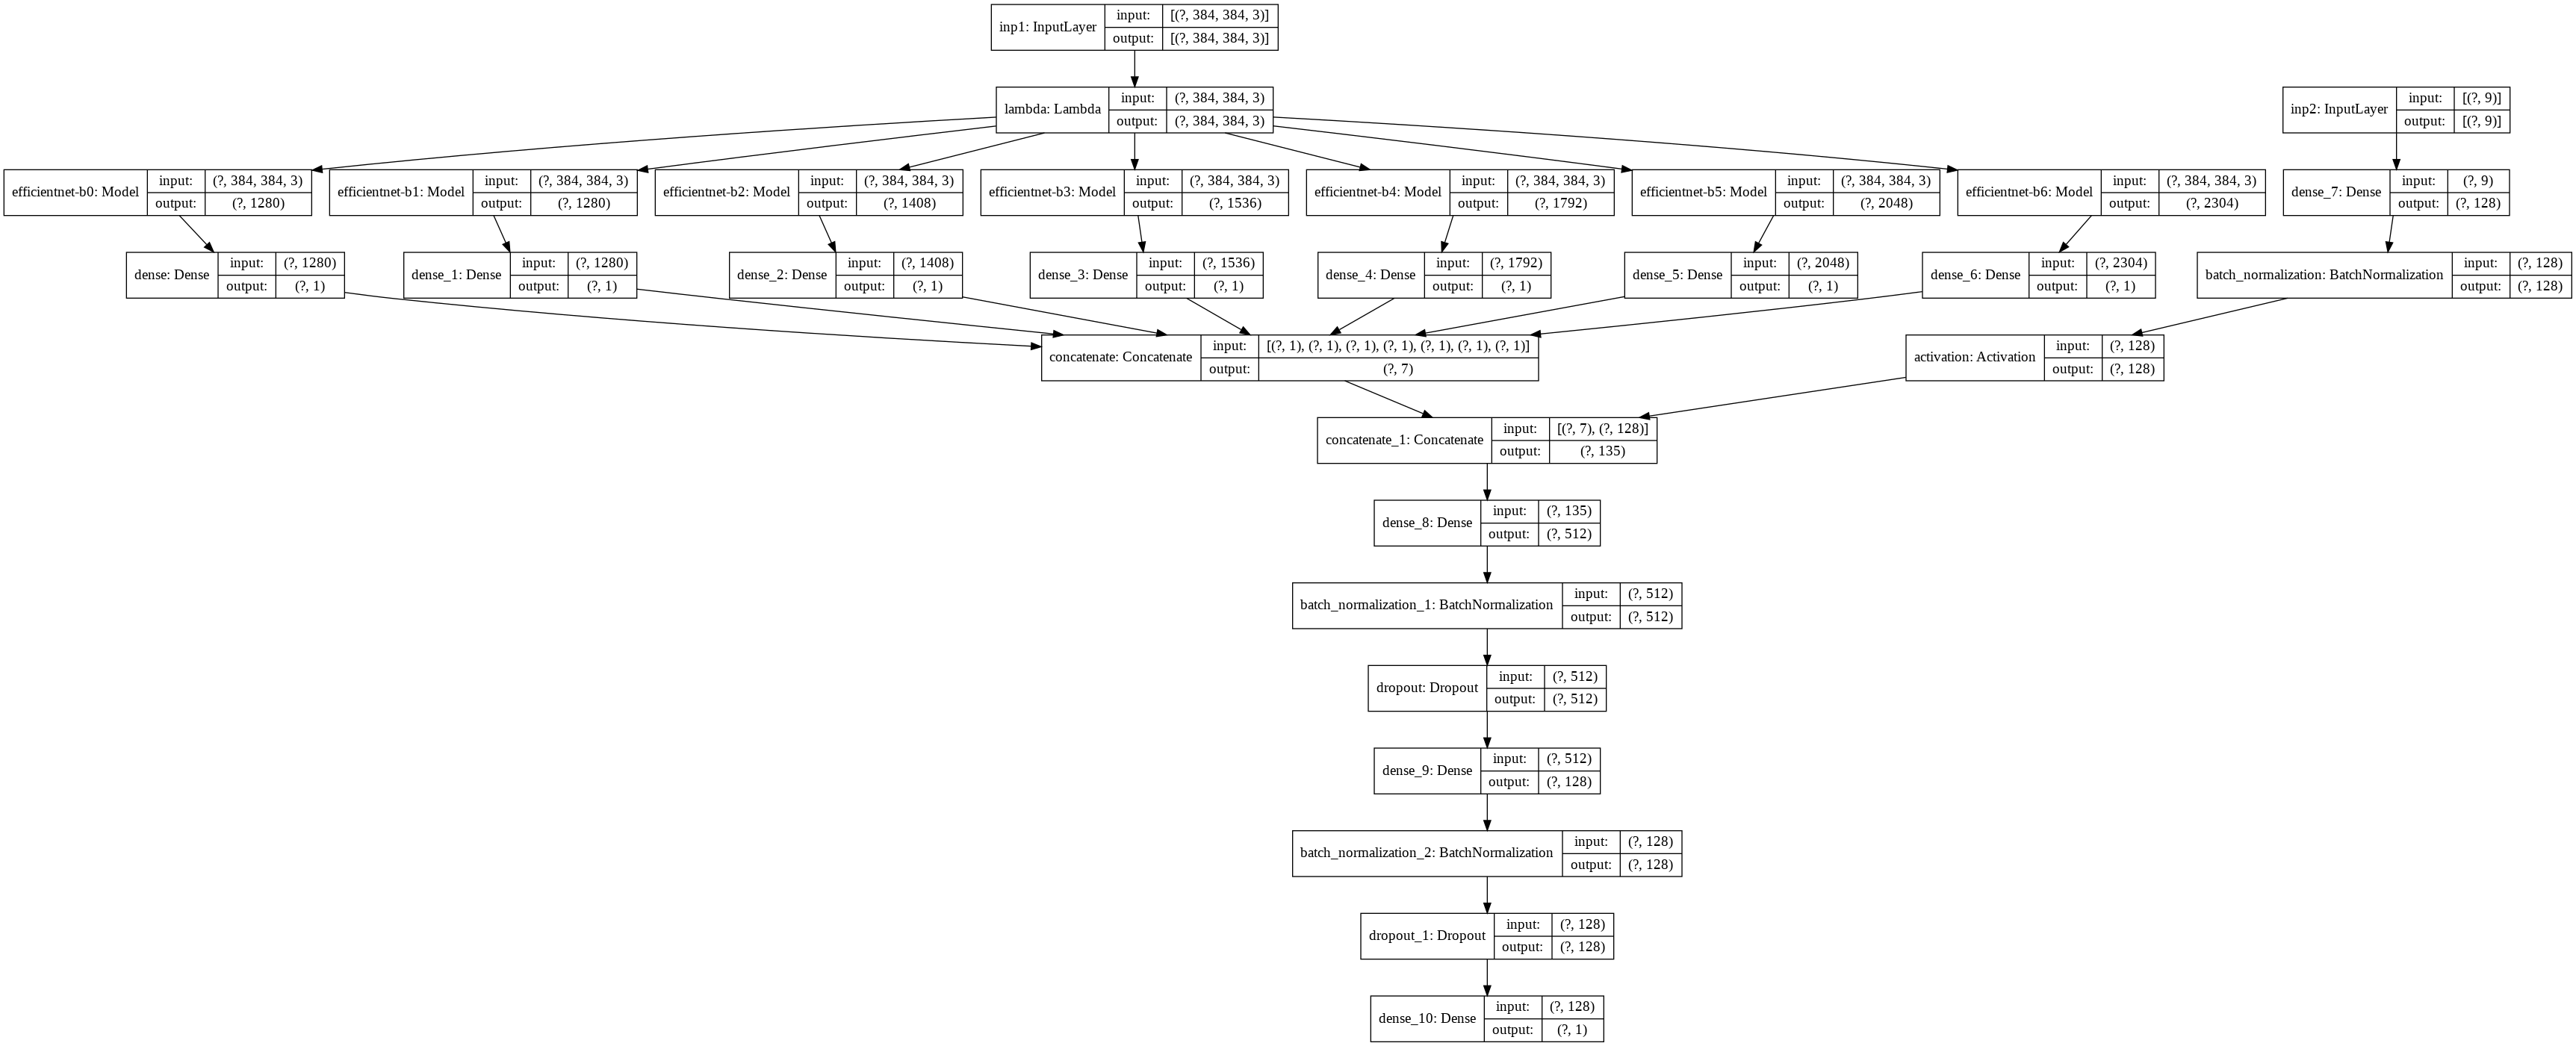

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
model = train_giant_model(model)
model.save_weights("huge_effnet_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Making predictions

In [ ]:
test_ds = get_test_dataset(TEST_FILENAMES, labeled = False, ordered = True)
test_images_ds = test_ds.map(lambda image, image_name: image)

print('Computing predictions...')
probabilities = np.average(model.predict(test_images_ds, verbose=1), axis = 0)
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, image_name: image_name).unbatch()
# all in one batch
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
pred_df = pd.DataFrame({'image_name': test_ids, 'target': probabilities})

Computing predictions...
86/86 [==============================] - 16s 190ms/step
Generating submission.csv file...


# Submission process

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [ ]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('multi_inp.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.001498
1,ISIC_0052349,0.000330
2,ISIC_0058510,0.001635
3,ISIC_0073313,0.002888
4,ISIC_0073502,0.009865


In [ ]:
import gc
gc.collect()

154431